In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from p6_rotations import topology_to_list
from p9_sp_clusters_data import *
from joblib import dump, load


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Data Preprocessing


In [252]:
#importing data frames
all_csv = pd.read_csv('all.csv').drop(['Unnamed: 0','all_corners_comb','all_edges_comb','no_edges_comb','no_corners_comb','all_comb'],axis=1)
df = pd.DataFrame(data=list_of_sp_clusters, columns = ['full_notation','energy','SCF_steps','magnetism','time_of_calculation'])
real_benchmark = pd.read_csv('benchmark_ds.csv').drop(['index','Unnamed: 7'],axis=1)

#creating full notation column in benchmark
real_benchmark['full_notation'] = real_benchmark['energy']
for cluster in range(len(real_benchmark)):
    real_benchmark['full_notation'].iloc[cluster] = str(real_benchmark['no_cluster'].iloc[cluster]) + '_'+real_benchmark['joining_type'].iloc[cluster]+'_'+real_benchmark['rotation'].iloc[cluster]

#creating new columns in df:
for column in ['no_nickel','number','joining_type','first_atom','second_atom','topology','c_atom','mass_center','shortest_paths','conformation','bonds']:
    df[column] = df['magnetism'] 

#gathering data from full notation columns
for cluster in range(len(df)):
    df['number'].iloc[cluster] = df['full_notation'].iloc[cluster].split('_')[0] 
    df['joining_type'].iloc[cluster] = df['full_notation'].iloc[cluster].split('_')[1]
    df['first_atom'].iloc[cluster] = int(df['full_notation'].iloc[cluster].split('_')[2])
    df['second_atom'].iloc[cluster] = int(df['full_notation'].iloc[cluster].split('_')[3])
    df['energy'].iloc[cluster] = float(df['energy'].iloc[cluster][1:])

#splitting shortest paths, conformation and bonds
for column in ['ni_ncentre','ni_centre','cu_ncentre','cu_centre','0ni','8ni','17ni','25ni','33ni','42ni','50ni', 'nini','cucu','nicu','type_of_first_atom','type_of_second_atom', 'hydrogen']:
    df[column] = df['magnetism']    

#gathering data from all.csv file and splitting shortest paths, conformation and bonds
for cluster in range(len(df)):
    for column in ['no_nickel','c_atom','mass_center','shortest_paths','conformation','bonds']:
        df[column].iloc[cluster] = all_csv[column].loc[int(df['number'].iloc[cluster])]
    for column in ['topology']:
        df[column].iloc[cluster] = topology_to_list(all_csv[column].loc[int(df['number'].iloc[cluster])])
    df['ni_ncentre'].iloc[cluster] = int(str(df['shortest_paths'].iloc[cluster].split(',')[0])[1:])
    df['ni_centre'].iloc[cluster] = int(df['shortest_paths'].iloc[cluster].split(',')[1])
    df['cu_ncentre'].iloc[cluster] = int(df['shortest_paths'].iloc[cluster].split(',')[2])
    df['cu_centre'].iloc[cluster] = int(str(df['shortest_paths'].iloc[cluster].split(',')[3])[:-1])
    df['0ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[0])[1:])
    df['50ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[6])[:-1])
    df['8ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[1]))
    df['17ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[2]))
    df['25ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[3]))
    df['33ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[4]))
    df['42ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[5]))
    df['nini'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[0])[1:])
    df['cucu'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[2])[:-1])
    df['nicu'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[1]))
    df['type_of_first_atom'].iloc[cluster] = df['topology'].iloc[cluster][df['first_atom'].iloc[cluster]]
    df['type_of_second_atom'].iloc[cluster] = df['topology'].iloc[cluster][df['second_atom'].iloc[cluster]]
    if df['joining_type'].iloc[cluster] in ['MOCOM','MOCM_H_n_bond']:
        df['hydrogen'].iloc[cluster] = 1
    else:
        df['hydrogen'].iloc[cluster] = 0

#df = df[(df['joining_type']=='MOCMHnbond') | (df['joining_type']=='MOCOM') | (df['joining_type']=='MOCM')]
#df = df[df['no_nickel'] <12]
#df = df[df['no_nickel'] >2]
print('len:', len(df))
print(df['joining_type'].unique())
print(df['no_nickel'].unique())

full_dataset = df.drop(['conformation','shortest_paths','bonds'],axis=1)
full_dataset.columns


C:\Users\stott\AppData\Local\Temp\ipykernel_10712\1665218395.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_benchmark['full_notation'].iloc[cluster] = str(real_benchmark['no_cluster'].iloc[cluster]) + '_'+real_benchmark['joining_type'].iloc[cluster]+'_'+real_benchmark['rotation'].iloc[cluster]


len: 649
['MO' 'MOCOM' 'MC' 'MOCMHnbond' 'MOCM']
[6 5 4 7 3 1 2 9 11 8 12 10]


Index(['full_notation', 'energy', 'SCF_steps', 'magnetism',
       'time_of_calculation', 'no_nickel', 'number', 'joining_type',
       'first_atom', 'second_atom', 'topology', 'c_atom', 'mass_center',
       'ni_ncentre', 'ni_centre', 'cu_ncentre', 'cu_centre', '0ni', '8ni',
       '17ni', '25ni', '33ni', '42ni', '50ni', 'nini', 'cucu', 'nicu',
       'type_of_first_atom', 'type_of_second_atom', 'hydrogen'],
      dtype='object')

## Creating Some Benchmarks

In [310]:
print('len of full_dataset:',len(full_dataset))
print('len of testing benchmark:', len(sp_on_benchmark_cases))
print(full_dataset['joining_type'].value_counts())
print(full_dataset['no_nickel'].value_counts())

equall_df = pd.DataFrame(columns=full_dataset.columns)
helpfull_df = pd.DataFrame(columns = full_dataset.columns)
#I need to gather the same number of whole cases --> I have exactly one type of every joinning type in no_nickel = 12 so I pick exactly one cluster for every number of nickel and joining type
for joining_type in ['MC','MOCOM','MOCMHnbond','MO','MOCM']:
    helpfull_df = full_dataset[(full_dataset['joining_type']==joining_type)]
    equall_df = pd.concat([equall_df, helpfull_df.sample(40)])


benchmark1 = pd.DataFrame(columns = full_dataset.columns)
for nickel in range(1,13):
    for joining_type in ['MC','MOCOM','MOCMHnbond','MO','MOCM']:
        
        helpfull_df = ((full_dataset[(full_dataset['joining_type']==joining_type) & (full_dataset['no_nickel']==nickel)]))
        if len(helpfull_df) != 0:
            benchmark1 = pd.concat([benchmark1,helpfull_df.sample()])

#of course due to not converting some of clusters, exactly one data (1_MOCM) was missed, eqaul_df is the first benchmark data set

#another benchmarks is from sp_on_benchmark cluster

#no_nickel,shortest_paths,conformation,bonds
list_of_cluster_benchmark = pd.DataFrame(data = [
[180,['Ni', 'Cu', 'Cu', 'Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni'],10,1,0.03923,9, 10, 3, 3,0, 0, 0, 0, 6, 3, 3,54, 6, 24],
[165,['Ni', 'Cu', 'Cu', 'Cu', 'Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni'],9,1,0.0445,8, 9, 4, 4,0, 0, 0, 2, 6, 2, 2,46, 10, 28],
[190,['Ni', 'Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni'],12,1,0.01705,11, 12, 1, 1,0, 0, 0, 0, 0, 5, 7,72, 0, 12],
[146,['Ni', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni'],8,1,0.04651,7, 8, 5, 5,0, 0, 1, 3, 5, 2, 1,38, 14, 32],
[186,['Ni', 'Cu', 'Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni'],11,1,0.02846,10, 11, 2, 2,0, 0, 0, 0, 2, 6, 4,62, 2, 20],
[181,['Ni', 'Cu', 'Cu', 'Ni', 'Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni'],10,1,0.03234,9, 10, 3, 3,0, 0, 0, 1, 3, 6, 2,52, 4, 28],
[2,['Cu', 'Ni', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu'],1,0,0.01372,1, 1, 11, 12,7, 5, 0, 0, 0, 0, 0,0, 72, 12],
[4,['Cu', 'Ni', 'Ni', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu'],2,0,0.02363,2, 2, 10, 11,4, 6, 2, 0, 0, 0, 0,2, 62, 20],
[44,['Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu'],5,0,0.04318,5, 5, 7, 8,1, 2, 5, 3, 1, 0, 0,14, 38, 32],
[72,['Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu'],6,0,0.0481,6, 6, 6, 7,1, 0, 5, 5, 0, 1, 0,20, 32, 32]], columns = ['number','topology','no_nickel','c_atom','mass_center','ni_ncentre', 'ni_centre','cu_ncentre', 'cu_centre','0ni', '8ni', '17ni', '25ni', '33ni', '42ni','50ni', 'nini', 'cucu', 'nicu'])


benchmark2 = pd.DataFrame(data = sp_on_benchmark_cases, columns = ['full_notation','energy','SCF_steps','magnetism','time_of_calculation'])

for column in ['hydrogen','type_of_first_atom','type_of_second_atom','first_atom','second_atom','joining_type','number']:
     benchmark2[column] = benchmark2['full_notation']

for cluster in range(len(benchmark2)):
    benchmark2['number'].iloc[cluster] = int(benchmark2['full_notation'].iloc[cluster].split('_')[0])
    benchmark2['joining_type'].iloc[cluster] = benchmark2['full_notation'].iloc[cluster].split('_')[1]
    benchmark2['first_atom'].iloc[cluster] = int(benchmark2['full_notation'].iloc[cluster].split('_')[2])
    benchmark2['second_atom'].iloc[cluster] = int(benchmark2['full_notation'].iloc[cluster].split('_')[3])  
    if benchmark2['joining_type'].iloc[cluster] in ['MO','MOCM']:
        benchmark2['hydrogen'].iloc[cluster] = 1
    else:
        benchmark2['hydrogen'].iloc[cluster] = 0
    for bench in range(len(real_benchmark)):
        if benchmark2['full_notation'].iloc[cluster] == real_benchmark['full_notation'].iloc[bench]:
            benchmark2['energy'].iloc[cluster] = real_benchmark['energy'].iloc[bench]
    benchmark2['energy'].iloc[cluster] = float(str(benchmark2['energy'].iloc[cluster])[1:])
    
benchmark2 = benchmark2.merge(list_of_cluster_benchmark, left_on='number', right_on = 'number', validate='m:1')

for cluster in range(len(benchmark2)):
    benchmark2['type_of_first_atom'].iloc[cluster] = benchmark2['topology'].iloc[cluster][benchmark2['first_atom'].iloc[cluster]]
    benchmark2['type_of_second_atom'].iloc[cluster] = benchmark2['topology'].iloc[cluster][benchmark2['second_atom'].iloc[cluster]]




len of full_dataset: 649
len of testing benchmark: 26
MO            229
MOCOM         216
MC             74
MOCMHnbond     70
MOCM           60
Name: joining_type, dtype: int64
6     213
7     160
5      83
4      72
3      40
2      21
8      15
1      12
11     10
9       9
10      9
12      5
Name: no_nickel, dtype: int64


C:\Users\stott\AppData\Local\Temp\ipykernel_10712\327279530.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark2['type_of_first_atom'].iloc[cluster] = benchmark2['topology'].iloc[cluster][benchmark2['first_atom'].iloc[cluster]]
C:\Users\stott\AppData\Local\Temp\ipykernel_10712\327279530.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark2['type_of_second_atom'].iloc[cluster] = benchmark2['topology'].iloc[cluster][benchmark2['second_atom'].iloc[cluster]]


## Functions to create ML model

In [344]:
def ada(X_train,X_test,y_train,y_test, estimators= [50,100,150,200,250,300], lr = [0.2,0.4,0.6,0.8,1,1.5,2,3]):
    
    best_acc = [0]
    for est in estimators:
        for learning_rate in lr:  
        
            model = AdaBoostRegressor(n_estimators=est, learning_rate=learning_rate)    
            model.fit(X_train, y_train)
            model_pred = model.predict(X_test)

            srednia_error = 0    

            for i in range(len(model_pred)):
                srednia_error+= np.sqrt((model_pred[i]-y_test[i])**2)            
            srednia_error /= len(model_pred)   

            acc = 1-(srednia_error/(max(y_test)-min(y_test)))   
            
            if acc > best_acc[0]:
                best_acc = [acc, 'ada',  'est:',est, 'learning rate:',learning_rate]
                dump(model, 'model_ada.joblib') 

            
            print('acc:',acc, 'type of alg: ada', 'est:', est, 'learning rate:', learning_rate)       
    return(best_acc, y_test, model_pred)

def rf(X_train,X_test,y_train,y_test, estimators= [50,100,150,200,250,300]):
    
    best_acc = [0]
    for est in estimators:

        model = RandomForestRegressor(n_estimators=est)  
        
        model.fit(X_train, y_train)
        model_pred = model.predict(X_test)

        srednia_error = 0    
        for i in range(len(model_pred)):
            srednia_error+= np.sqrt((model_pred[i]-y_test[i])**2)            
        srednia_error /= len(model_pred)   

        acc = 1-(srednia_error/(max(y_test)-min(y_test)))   

        if acc > best_acc[0]:
            best_acc = [acc, 'rf', 'est:' , est,]
            dump(model, 'model_rf.joblib') 
        
        print('acc:',acc, 'type of alg:', 'rf', 'est:', est)   
    
    return(best_acc, y_test, model_pred)

def brf(X_train,X_test,y_train,y_test, estimators= [50,100,150,200,250,300], lr = [0.2,0.4,0.6,0.8,1,1.5,2,3], md = [1,2,3]):
    
    best_acc = [0]
    for est in estimators:
        for learning_rate in lr:
            for max_depth in md:
    
                model = GradientBoostingRegressor(n_estimators=est, learning_rate=learning_rate, max_depth=max_depth)  

                model.fit(X_train, y_train)
                model_pred = model.predict(X_test)

                srednia_error = 0    

                for i in range(len(model_pred)):
                    srednia_error+= np.sqrt((model_pred[i]-y_test[i])**2)            
                srednia_error /= len(model_pred)   

                acc = 1-(srednia_error/(max(y_test)-min(y_test)))   

                if acc > best_acc[0]:
                    best_acc = [acc, 'brf', 'est:' ,est, 'learning rate:', learning_rate, 'max_depth:',max_depth]
                    dump(model, 'model_brf.joblib') 
                print('acc:',acc, 'type of alg:', 'brf', 'est:', est, 'learning rate:', learning_rate, 'max depth:', max_depth)    

    return(best_acc, y_test, model_pred)

def svr(X_train,X_test,y_train,y_test, C_parameter = [0.2,0.4,0.6,0.8,1,1.5,2,3], degrees = [x for x in range(1,8)]):
    
    best_acc = [0]
    for C in C_parameter:
        for degree in degrees:
            
                model = SVR(C=C,degree = degree)
                model.fit(X_train, y_train)
                model_pred = model.predict(X_test)

                srednia_error = 0    

                for i in range(len(model_pred)):
                    srednia_error+= np.sqrt((model_pred[i]-y_test[i])**2)            
                srednia_error /= len(model_pred)   

                acc = 1-(srednia_error/(max(y_test)-min(y_test)))   

                if acc > best_acc[0]:
                    best_acc = [acc, 'svr', 'C: ', C,'degree:', degree]
                    dump(model, 'model_svr.joblib') 
                print('acc:',acc, 'type of alg:' 'C:', C, 'degree:', degree)   
    
    return(best_acc, y_test, model_pred)

def printing(model, y_test, nn=False):  
    frame = []

    if nn == True:
        for char in range(len(model)):
            preframe = []
            preframe.append(model[char][0])
            preframe.append(y_test[char])
            frame.append(preframe)  
    else:
        for char in range(len(model)):
            preframe = []
            preframe.append(model[char])
            preframe.append(y_test[char])
            frame.append(preframe) 
    frame = pd.DataFrame(data=frame, columns =['y_test','model_pred'])  
    scaler = MinMaxScaler()
    scaler.fit(frame)
    frame = scaler.transform(frame)
    frame = pd.DataFrame(data=frame, columns = ['y_test','model_pred']) 
    frame = frame.sort_values(by=['y_test']).reset_index(drop=True)
    acc = 1-(sum(((frame['model_pred']-frame['y_test'])**2)**(0.5))/len(frame))
    print(acc)
    markers = {"y_test": "s", "model_pred": "h"}
    ax = sns.scatterplot(data=frame, markers=markers, s = 110) 
    return ax 
def data_scaling(data):
    X = data.drop(['energy','first_atom','second_atom','SCF_steps','magnetism','time_of_calculation','number','full_notation','joining_type','topology'],axis=1)
    X = pd.get_dummies(data = X, columns = ['type_of_first_atom','type_of_second_atom'], drop_first=True)
    y = np.asarray(data['energy']).astype('float32')
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    X = pd.DataFrame(data=X)
    return X,y

def create_model(X, activation, n):
    
    model = Sequential()
    model.add(Dense(units=len(X.columns), activation=activation, input_dim=len(X.columns)))
    for layer in range(1,n):
            model.add(Dense(units=4*2**layer, activation='relu'))
    model.add(Dense(units=1, activation=activation))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

def nn(X_train,X_test,y_train,y_test, layer = [2,3,4,5], batchs = [8,16,32,64]):    
    best_acc = [0]
    for activation in ['relu','linear']:
        for n in layer:
            for batch in batchs:
                early_stop = EarlyStopping(monitor='loss', mode='min', patience=15, restore_best_weights = True)
                model = create_model(X_train,activation,n)
                model.fit(X_train, y_train, epochs=300, batch_size=batch, callbacks=[early_stop], verbose = 0)
                model_pred = model.predict(X_test) 
                srednia_error = 0    

                for i in range(len(model_pred)):
                    srednia_error+= np.sqrt((model_pred[i][0]-y_test[i])**2)            
                srednia_error /= len(model_pred)   

                acc = 1-(srednia_error/(max(y_test)-min(y_test)))   
                print('acc:',acc, 'act:', activation, 'number_of_layers:', n, 'batch: ', batch)
                if acc > best_acc[0]:
                    best_acc = [acc, activation, n, batch]
                    model.save('model_nn.h5') 
    print(best_acc)
    return best_acc
    

## Training ML model

In [311]:
partial_dataset = equall_df
#partial_dataset = equall_df[(equall_df['joining_type'] == 'MC') | (equall_df['joining_type']=='MOCM')]
#partial_dataset = full_dataset[(full_dataset['joining_type']=='MOCOM') | (full_dataset['joining_type']=='MO')]
partial_dataset = partial_dataset[partial_dataset['no_nickel'] <12]
partial_dataset = partial_dataset[partial_dataset['no_nickel'] >2]
ml_alg = ['ada','rf','brf','svr']
print('len:', len(partial_dataset))
print(partial_dataset['joining_type'].unique())
print(partial_dataset['no_nickel'].unique())

best_acc = [0]
X = data_scaling(partial_dataset)[0]
y = data_scaling(partial_dataset)[1]    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

best_ada = ada(X_train,X_test,y_train,y_test)
best_rf = rf(X_train,X_test,y_train,y_test)
best_brf = brf(X_train,X_test,y_train,y_test)
best_svr = svr(X_train,X_test,y_train,y_test)
#best_nn = nn(X_train,X_test,y_train,y_test)

for alg in [best_ada,best_rf,best_brf,best_svr]:
    try:
        print(alg[0])
    except:
        continue
try:
    print(best_nn)
except:
    pass




len: 189
['MC' 'MOCOM' 'MOCMHnbond' 'MO' 'MOCM']
[6 5 7 11 4 3 10 8 9]
acc: 0.8353354280974232 type of alg: ada est: 50 learning rate: 0.2
acc: 0.8321409623550077 type of alg: ada est: 50 learning rate: 0.4
acc: 0.8355486285269675 type of alg: ada est: 50 learning rate: 0.6
acc: 0.8368611630517667 type of alg: ada est: 50 learning rate: 0.8
acc: 0.8364690689340695 type of alg: ada est: 50 learning rate: 1
acc: 0.8312249029131323 type of alg: ada est: 50 learning rate: 1.5
acc: 0.8312375803024268 type of alg: ada est: 50 learning rate: 2
acc: 0.8265599516054761 type of alg: ada est: 50 learning rate: 3
acc: 0.8347122568448605 type of alg: ada est: 100 learning rate: 0.2
acc: 0.8330295081731921 type of alg: ada est: 100 learning rate: 0.4
acc: 0.8311342977677618 type of alg: ada est: 100 learning rate: 0.6
acc: 0.8297310559846787 type of alg: ada est: 100 learning rate: 0.8
acc: 0.8404137672819116 type of alg: ada est: 100 learning rate: 1
acc: 0.831109656561964 type of alg: ada est: 100

0.8951526152820053


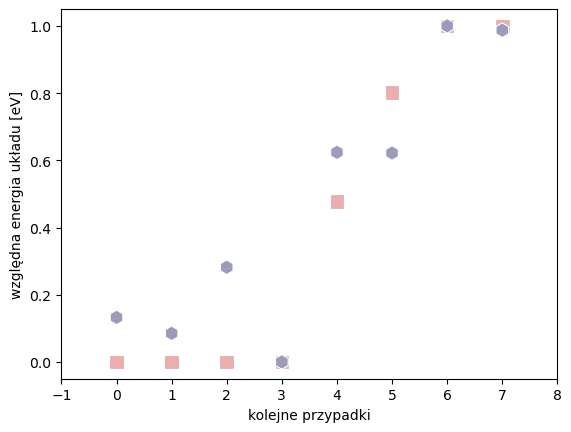

In [380]:
#ml printing
model = load('MC_MOCM_60r.joblib')
model_pred = model.predict(X_test)
#printing(model_pred,y_test)

chosen_bench = benchmark2
benchmark = chosen_bench[chosen_bench['joining_type']=='MOCM']
X = data_scaling(benchmark)[0]
y = data_scaling(benchmark)[1]
model_pred = model.predict(X)
ax = printing(model_pred,y)
ax.get_legend().remove()
ax.set_xlabel("kolejne przypadki")
ax.set_ylabel("względna energia układu [eV]")
ax.set_xlim(-1,8)
plt.savefig('MOCM_b2_60r.png')

0.4738198500461447


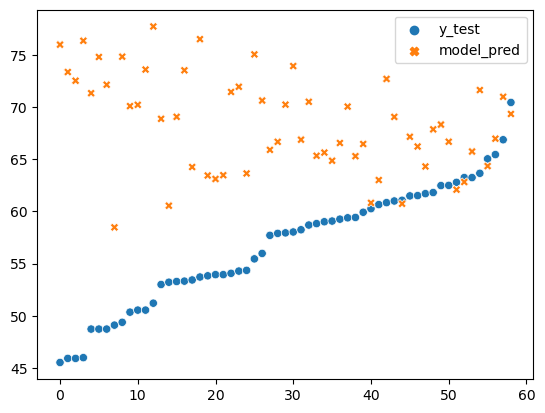

In [34]:
#nn printing
model = load_model('model_trained_by.h5')
model_pred = model.predict(X_test)
#printing(model_pred,y_test, nn=True)

benchmark = benchmark1
X = data_scaling(benchmark)[0]
y = data_scaling(benchmark)[1]
model_pred = model.predict(X)
test = printing(model_pred,y, nn=True)

## Drawing Aproximate Accuracy Plot

In [324]:
sp_on_benchmark_cases = pd.DataFrame(data=sp_on_benchmark_cases, columns = ['full_notation','aproximate_energy','SCF_steps','magnetism','time'])
for char in range(len(sp_on_benchmark_cases)):
    sp_on_benchmark_cases['aproximate_energy'].iloc[char] = float(sp_on_benchmark_cases['aproximate_energy'].iloc[char])
benchmark_merge = benchmark.merge(sp_on_benchmark_cases, left_on='full_notation', right_on='full_notation')
benchmark_merge = benchmark_merge[['energy','aproximate_energy']].sort_values(by=['energy']).reset_index(drop=True)

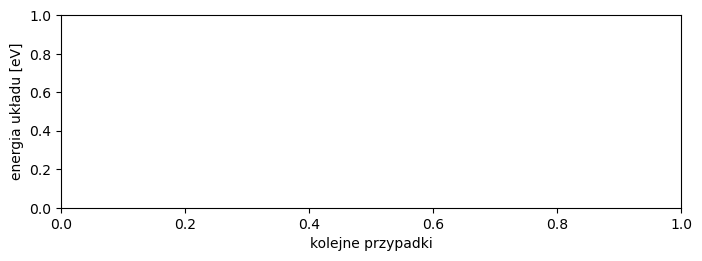

In [325]:

colors = ['#e9aeae','#9b9bba']

sns.set_palette(sns.color_palette(colors))
markers = {"energy": "h", "aproximate_energy": "o"}
plt.figure(figsize=(8,2.5))
ax = sns.scatterplot(data = benchmark_merge, markers=markers, legend= False )
ax.set_xlabel("kolejne przypadki")
ax.set_ylabel("energia układu [eV]")


f = plt.savefig('aproximate_accuracy.png')